In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import os
import glob
import datetime
import pytz
import seaborn as sns

warnings.filterwarnings('ignore')

In [8]:
path =  "./data"
llamaPath = "./lag-llama"

In [9]:
df = pd.read_csv(f"{path}/train.csv", parse_dates=["date"], index_col="date")
df

,power,temperature,apparentTemperature,hourOfDay,dewPoint,pressure,visibility,windBearing,windSpeed,humidity,dayOfMonth,dayOfWeek
date,,,,,,,,,,,,
2016-02-01 00:00:00-05:00,10360.396733,39.49,34.94,0,30.75,1007.92,10.0,189,6.32,0.71,1,0
2016-02-01 01:00:00-05:00,9570.685767,38.19,32.81,1,31.34,1006.68,10.0,199,7.25,0.76,1,0
2016-02-01 02:00:00-05:00,9363.859150,38.94,33.36,2,32.46,1005.91,10.0,195,7.87,0.77,1,0
2016-02-01 03:00:00-05:00,9356.058217,38.26,33.12,3,32.79,1005.27,10.0,194,6.88,0.80,1,0
2016-02-01 04:00:00-05:00,9172.311817,38.16,33.25,4,32.79,1004.85,10.0,205,6.47,0.81,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-02 19:00:00-05:00,15253.919833,25.50,13.59,19,10.45,1012.55,10.0,299,14.22,0.52,2,2
2016-03-02 20:00:00-05:00,16657.333417,24.32,12.89,20,9.61,1013.58,10.0,304,12.47,0.53,2,2
2016-03-02 21:00:00-05:00,16436.806817,23.36,10.17,21,7.93,1015.01,10.0,306,15.86,0.51,2,2


In [4]:
# Clone, prepare and download the model 
! git clone https://github.com/time-series-foundation-models/lag-llama/
! cd ./lag-llama 
! pip install -r requirements.txt
! huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./lag-llama

fatal: destination path 'lag-llama' already exists and is not an empty directory.


lag-llama/lag-llama.ckpt


In [7]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset

from lag_llama.gluon.estimator import LagLlamaEstimator

import datetime
import pytz
import seaborn as sns

warnings.filterwarnings('ignore')

In [15]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load(f"{llamaPath}/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path=f"{llamaPath}/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [64]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create Pandas
dataset = PandasDataset(df, target="power")

backtest_dataset = dataset
prediction_length = 48  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
context_length = 480
ropeScaling = False
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [65]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, context_length=context_length, num_samples=num_samples, use_rope_scaling=ropeScaling)

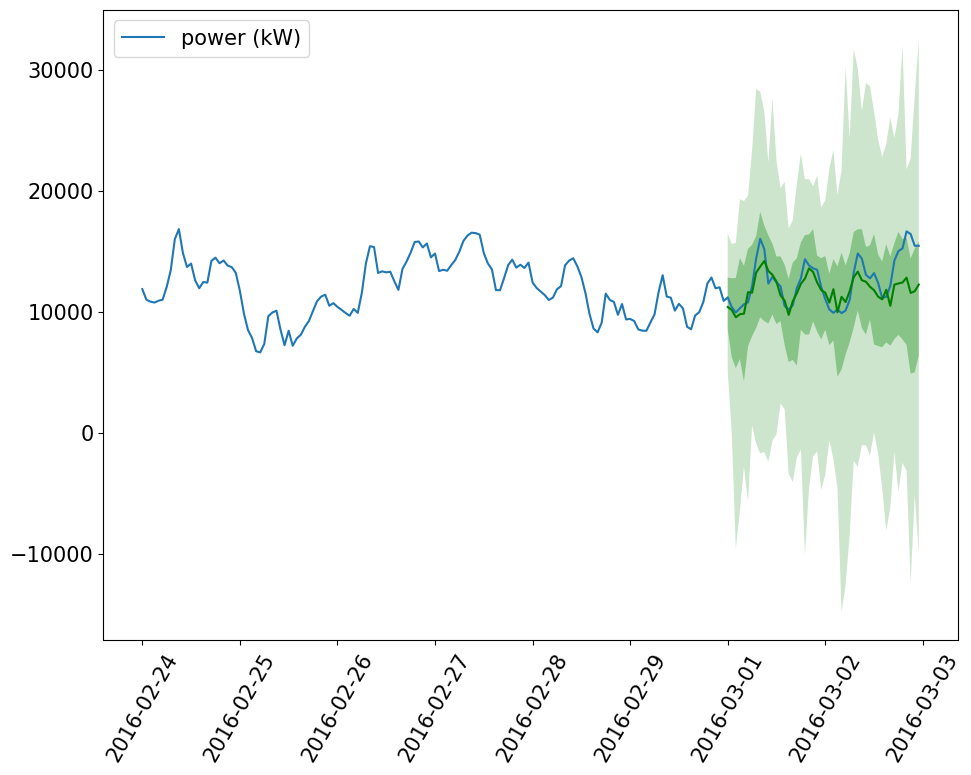

In [68]:
fig = plt.figure(figsize=(10, 8))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="power (kW)", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()